In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as const
from matplotlib.animation import FuncAnimation
import pickle
from math import sqrt

## Load Data
* To load data, set the `sim_name` property which will gather output data from `./simulations/<sim_name>`
* This means the simulation needs to have run before you can analyse the data

In [3]:
sim_name = 'liquid_energy'
df = np.load('./simulations/'+ sim_name + '/'+sim_name +'.npy')
rdf_data = np.load('./simulations/'+ sim_name + '/'+sim_name +'_rdf_data.npy')
with open('./simulations/' + sim_name + '/' + 'simulation_params_for_analysis.pkl', 'rb') as inp:
    sim_params = pickle.load(inp)
    

## Calculating Temperature
1. First we need to look through our dataframe, and for each timestep (exlcuding the first since here everything is 0) we need to calculate temperature
2. To do so, we get the average kinetic energy by:

$$\langle E_k \rangle = N \cdot f \cdot \frac{1}{2}kT$$ 

Where $f$ is the number of degrees of freedom. Since we are working in 2-D, $f=2$. So we have for a single timestep:

$$\langle E_k \rangle_{timestep} = NkT = \sum_{n=0}^{N} \frac{1}{2}mv^2$$ 

And so:

$$ T = \frac{1}{N\cdot k} \sum_{n=0}^{N} \frac{1}{2}mv^2$$
$$ T = \frac{1}{k} \langle E_{KE} \rangle$$

Here we will divide by Avogadro's constant since we are working with very few particles (usually $N\approx10^{23}$)

![./quantities.png](./quantities.png)

In [4]:
# calculating temperature
# to access variables: timestep[:,column] : means all rows, columns are as follows:
# 0 = p.x
# 1 = p.y
# 2 = p.kinetic_energy (1/2mv^2)
# 3 = p.potential_energy (calculated using LJ potential. record_potential needs to be True)
# 4 = p.force_on_wall (force exerted by that particle on all walls during that timestep)
# 5 = p.velocity (norm of velocity vectors - since mass=1, velocity=momentum
temps = []
boltzman = const.k
dimensions = 2
epsilon = sim_params['epsilon']
num_particles = sim_params['num_particles']
for timestep in df[1:]:
    sum_kinetic_energy = sum(timestep[:,2])
    
    T = 1/(dimensions*num_particles) * sum_kinetic_energy
    temps.append(T)
    

### Defining Units
In MD simulations usually $\sigma$, $m$ and $\epsilon$ are used to define dimensionless units of length, mass and energy respectively. These can then be converted into real units using the parameters for a molecule. 

* length: $r$ = $r\sigma$
* energy: $e$ = $e\epsilon$
* time: $t$ = $t\sqrt {m \sigma^2/\epsilon} $

![](./argon.png)

https://docs.lammps.org/units.html

0.001
1.08031713820097e-16


Text(0.5, 1.0, 'Temperature')

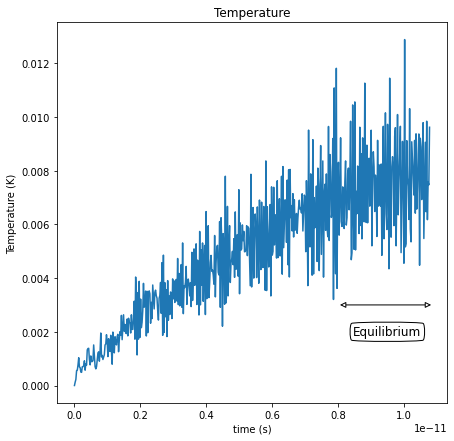

In [28]:
n=10
plt.clf()
ep_arg = 120 * 1.3806*1e-16
sigma_arg = 3.4 * 0.1e-9
mass_arg = 39.95*1.6747e-24
dt = sim_params['dt']
print(dt)
time = sqrt((mass_arg*sigma_arg**2)/ep_arg)
print(time*0.005)
timesteps = np.arange(0,len(temps[::n]),1)
plt.plot(timesteps*time, temps[::n])
plt.xlabel('time (s)')
plt.ylabel('Temperature (K)')
plt.rcParams["figure.figsize"] = (7,7)
# plt.annotate('Temperature Equilibration',
#                   xy=(0.2e-11, 0),
#                   xytext=(0, 0.3),
#                   size=12, va="center", ha="center",
#                   bbox=dict(boxstyle="round4", fc="w"),
#                   arrowprops=dict(arrowstyle="-|>",
#                                   connectionstyle="arc3",
#                                   fc="w"),
#                   )
# plt.annotate('Setting Desired Temperature',
#                   xy=(0.5e-11, 0.15),
#                   xytext=(1.1e-11, 0.1),
#                   size=12, va="center", ha="center",
#                   bbox=dict(boxstyle="round4", fc="w"),
#                   arrowprops=dict(arrowstyle="-|>",
#                                   connectionstyle="arc3",
#                                   fc="w"),
#                   )
# plt.annotate('Measuring Transitions',
#                   xy=(1.5e-11, 0.3),
#                   xytext=(1.5e-11, 0.45),
#                   size=12, va="center", ha="center",
#                   bbox=dict(boxstyle="round4", fc="w"),
#                   arrowprops=dict(arrowstyle="-|>",
#                                   connectionstyle="arc3",
#                                   fc="w"),
#                   )
plt.annotate('',
                  xy=(0.8e-11,0.003),
                  xytext=(1.1e-11,0.003),
                  size=12, va="center", ha="center",
                  bbox=dict(boxstyle="round4", fc="w"),
                  arrowprops=dict(arrowstyle="<|-|>",
                                  connectionstyle="arc3",
                                  fc="w"),
                  )
plt.annotate('Equilibrium',
                  xy=(0.95e-11,0.002),
                  xytext=(0.95e-11,0.002),
                  size=12, va="center", ha="center",
                  bbox=dict(boxstyle="round4", fc="w"),
                  arrowprops=dict(arrowstyle="<|-|>",
                                  connectionstyle="arc3",
                                  fc="w"),
                  )

plt.title('Temperature')

In [30]:
# grid locations for imaginary particles
grid_locations = df[1][:25][:,0:2]
print(grid_locations)
num_real_particles = sim_params['num_particles'] - 25
dist_between_absorption_sites = (df[1][0][0] - df[1][1][0])**2 + (df[1][0][1] - df[1][1][1])**2

# 0 is the first, index 5 to the right, 6 diagonal
dist_between_diagonal_absorption_sites = (df[1][0][0] - df[1][6][0])**2 + (df[1][0][1] - df[1][6][1])**2

[[10.          8.86607106]
 [12.26785789  7.73214211]
 [11.13392894 12.26785789]
 [11.13392894 10.        ]
 [12.26785789 11.13392894]
 [ 7.73214211 10.        ]
 [ 8.86607106 12.26785789]
 [ 8.86607106  8.86607106]
 [10.         11.13392894]
 [ 8.86607106 11.13392894]
 [12.26785789 12.26785789]
 [11.13392894  8.86607106]
 [12.26785789 10.        ]
 [ 7.73214211  7.73214211]
 [10.         12.26785789]
 [10.          7.73214211]
 [ 8.86607106  7.73214211]
 [11.13392894 11.13392894]
 [10.         10.        ]
 [ 7.73214211  8.86607106]
 [12.26785789  8.86607106]
 [11.13392894  7.73214211]
 [ 7.73214211 11.13392894]
 [ 7.73214211 12.26785789]
 [ 8.86607106 10.        ]]


In [31]:
# find the closest grid location for each particle
def find_closest_grid_locs(locations, grid_locations):
    closest_grid_locations = np.zeros(num_real_particles)
    indexes_abs = np.zeros(num_real_particles)
    indexes_atoms = np.zeros(num_real_particles)
    for j, location in enumerate(locations):
        closest = 400
        closest_index = -1
        for i, grid_point in enumerate(grid_locations):
            r2 = (location[0] - grid_point[0])**2 + (location[1] - grid_point[1])**2
            if r2 < closest:
                closest = r2
                closest_index = i
        closest_grid_locations[j] = closest_index
        indexes_abs[j] = closest_index
        indexes_atoms[j] = 25+j
    return (closest_grid_locations, indexes_abs, indexes_atoms)

grid_locs_arr = np.zeros((num_real_particles, len(df[1:])))
absorption_indexes_arr = np.zeros((num_real_particles, len(df[1:])))
atom_indexes_arr = np.zeros((num_real_particles, len(df[1:])))
for i in range(1,len(df[1:])):
    locations = df[i][25:][:,0:2]
    (closest_grid_locations, indexes_abs, indexes_atoms) = find_closest_grid_locs(locations, grid_locations)
    
    grid_locs_arr[:,i] = closest_grid_locations
    absorption_indexes_arr[:,i] = indexes_abs
    atom_indexes_arr[:,i] = indexes_atoms

In [32]:
imaginary_grid_locations = df[1][:25][:,0:2]
def find_indexes_of_sites_close(index_of_site):
    x = imaginary_grid_locations[index_of_site][0]
    y = imaginary_grid_locations[index_of_site][1]
    indexes_close = []
    indexes_diagonal = []
    for i, site in enumerate(imaginary_grid_locations):
        r2 = (x - site[0])**2 + (y-site[1])**2
        # make sure to not count the site itself
        if r2 < dist_between_absorption_sites*1.1 and r2 > dist_between_absorption_sites*0.9:
            indexes_close.append(i)
        if r2 < dist_between_diagonal_absorption_sites*1.1 and r2 > dist_between_diagonal_absorption_sites*0.9:
            indexes_diagonal.append(i)
    return (indexes_close, indexes_diagonal)

In [33]:
count_jumps = 0
for i in range(2,len(df[2:])):
    # this implies a particle transitioned
    if not (grid_locs_arr[:,i] == grid_locs_arr[:,i-1]).all():
        # now find the particle that moved
        for j in range(num_real_particles):
            if grid_locs_arr[j,i] != grid_locs_arr[j,i-1]:
                count_jumps += 1
                #index here is the index of the closest absorption site
                print("index_absorption: " +str(grid_locs_arr[j,i-1]))
                
                #index here is the index of the atom
                print("index_atom: " +str(atom_indexes_arr[j,i]))
                
                #closest absorption site before jump
                grid_locs_arr[j,i-1]
                #now need to calculate the number of particles which has the closest absorption site
                #which is within 2r of this site
                
                #1. find list of absorption sites within 2r before jump (this doesnt change with i)
                sites, sites_diagonal = find_indexes_of_sites_close(int(grid_locs_arr[j,i-1]))
                
                #2. check how many of these sites were occupied for i-1
                count_sites = len(sites)
                count_sites_diagonal = len(sites_diagonal)
                count_sites_total = count_sites + count_sites_diagonal
                occupied = 0
                for abs_site_index in sites:
                    for closest_site_index in grid_locs_arr[:,i-1]:
                        if int(closest_site_index) == abs_site_index:
                            occupied += 1
                occupied_diagonal = 0
                for abs_site_index in sites_diagonal:
                    for closest_site_index in grid_locs_arr[:,i-1]:
                        if int(closest_site_index) == abs_site_index:
                            occupied_diagonal += 1
                occupied_total = occupied + occupied_diagonal
                
                print("count_sites = " + str(count_sites))
                print("count_sites_diagonal = " + str(count_sites_diagonal))
                print("count_sites_total = " + str(count_sites_total))
                print("count_occupied = " + str(occupied))
                print("count_occupied_diagonal = " + str(occupied_diagonal))
                print("count_occupied_total = " + str(occupied_total))
                
        temperature = temps[i]
        print(temperature)
print(count_jumps)

0


In [34]:
timesteps = np.arange(0,len(df[1:]),1)
for i in range(18):
    plt.plot(timesteps, grid_locs_arr[i,:])
plt.xlabel('Timestep')
plt.ylabel('Index of closest absorption site')

IndexError: index 0 is out of bounds for axis 0 with size 0

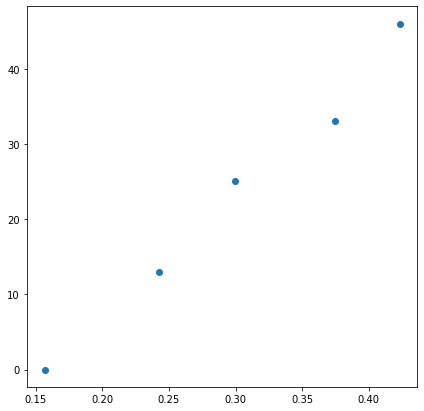

In [35]:
temps = np.array([0.15670787,0.24236571,0.29924725,0.374439 ,0.42310928])
jumps = [ 0, 13, 25, 33, 46]
plt.scatter(temps, jumps)

In [34]:
temp_jumps = np.load("./data/temp_jumps.npy")
jump_instances = np.load("./data/jump_instances.npy")
temp_jumps_2 = np.load("./data/temp_jumps_2.npy")
jump_instances_2 = np.load("./data/jump_instances_2.npy")
temp_jumps_3 = np.load("./data/temp_jumps_3.npy")
jump_instances_3 = np.load("./data/jump_instances_3.npy")
temp_jumps_3[0:60]

array([[ 0.16807632,  0.        ],
       [ 0.17328448,  0.        ],
       [ 0.15318782,  1.        ],
       [ 0.19036336,  0.        ],
       [ 0.2039667 ,  4.        ],
       [ 0.22940041,  2.        ],
       [ 0.2476308 , 10.        ],
       [ 0.21838655, 11.        ],
       [ 0.21923123,  8.        ],
       [ 0.24923632,  5.        ],
       [ 0.28585399, 20.        ],
       [ 0.27496978,  5.        ],
       [ 0.29329665, 18.        ],
       [ 0.28669912, 15.        ],
       [ 0.31773678, 17.        ],
       [ 0.28624668, 30.        ],
       [ 0.31649959, 21.        ],
       [ 0.3349416 , 18.        ],
       [ 0.31357564, 22.        ],
       [ 0.30640495, 12.        ],
       [ 0.29755486, 25.        ],
       [ 0.37278154, 24.        ],
       [ 0.39726166, 35.        ],
       [ 0.38525736, 30.        ],
       [ 0.38849098, 39.        ],
       [ 0.38736701, 24.        ],
       [ 0.47203272, 38.        ],
       [ 0.33663695, 20.        ],
       [ 0.48283822,

In [36]:
temp_jumps = np.concatenate((temp_jumps, temp_jumps_2[:50]))
jump_instances = np.concatenate((jump_instances, jump_instances_2[:50]))
x_dat = []

y_dat = []
for i in range(len(temp_jumps[:,1])):
    if temp_jumps[i,1]/temp_jumps[i,0] == 0:
        continue
    else:
        x_dat.append(1/temp_jumps[i,0])
        y_dat.append(np.log(temp_jumps[i,1]/temp_jumps[i,0]))

x_dat = np.array(x_dat)
y_dat = np.array(y_dat)

In [37]:
from scipy.optimize import curve_fit

In [38]:
def function_fit(x, m, b):
    return m*x + b

In [39]:
popt, pcov = curve_fit(function_fit, x_dat, y_dat)

Text(5, 4, '$r^2 = 0.5817 $')

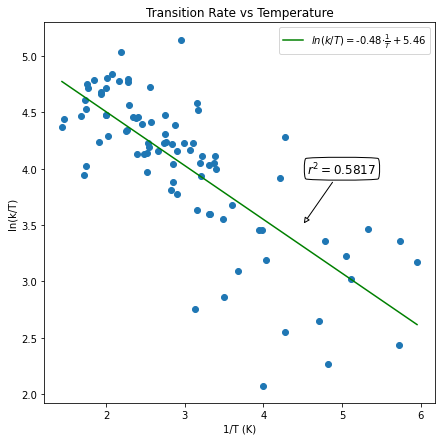

In [40]:
x_line = np.linspace(min(x_dat), max(x_dat), 100)
residuals = y_dat- function_fit(x_dat, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y_dat-np.mean(y_dat))**2)
r_squared = 1 - (ss_res / ss_tot)


y_line = popt[0]*x_line + popt[1]
plt.scatter(x_dat, y_dat)
plt.plot(x_line, y_line, 'g', label=r'$ln(k/T) = $' + str(round(popt[0],2)) + r'$\cdot\frac{1}{T} + $' + str(round(popt[1],2)) )
plt.title('Transition Rate vs Temperature')
plt.xlabel('1/T (K)')
plt.legend()
plt.ylabel('ln(k/T)')
plt.annotate(r'$r^2 = ' + str(round(r_squared,4)) + r' $',
                  xy=(4.5, 3.5),
                  xytext=(5, 4),
                  size=12, va="center", ha="center",
                  bbox=dict(boxstyle="round4", fc="w"),
                  arrowprops=dict(arrowstyle="-|>",
                                  connectionstyle="arc3",
                                  fc="w"),
                  )

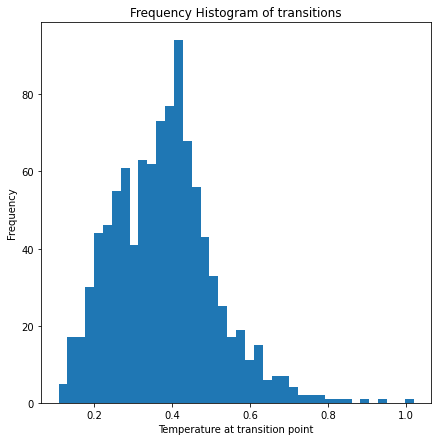

In [41]:
plt.hist(jump_instances[:,-1], bins=40)
plt.xlabel('Temperature at transition point')
plt.ylabel('Frequency of Transitions')
plt.gca().set(title='Frequency Histogram of transitions', ylabel='Frequency');

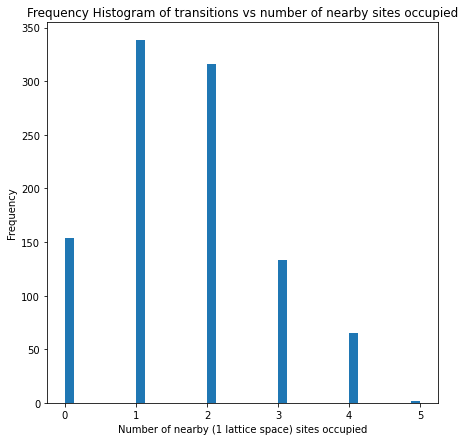

In [42]:
plt.hist(jump_instances[:,4], bins=40)
plt.xlabel('Number of nearby (1 lattice space) sites occupied')
plt.ylabel('Frequency of Transitions')
plt.gca().set(title='Frequency Histogram of transitions vs number of nearby sites occupied', ylabel='Frequency');

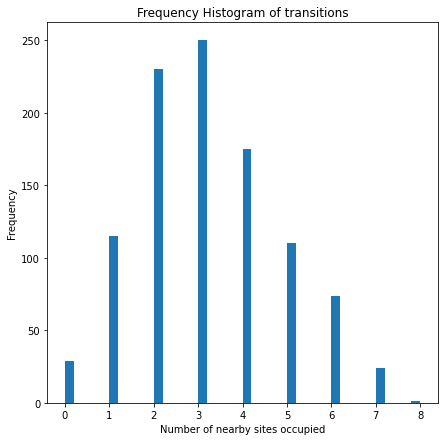

In [43]:
plt.hist(jump_instances[:,5], bins=40)
plt.xlabel('Number of nearby sites occupied')
plt.ylabel('Frequency of Transitions')
plt.gca().set(title='Frequency Histogram of transitions', ylabel='Frequency');

Notes
* How long does it take to get the thermal equilibrium 
* Why is the temperature not normally distributed
* How does the width (SD) of the gaussian vary with the number of atoms (fluctuations as a function of the system size)
* Go up and down by a factor of 5 after it has reached equilibrium and compare system fluctuations

## Distribution of Temperatures
* To Do

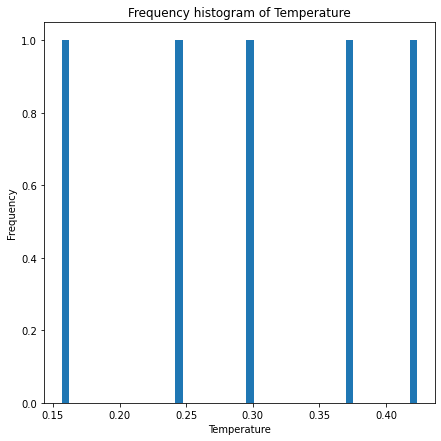

In [44]:
# mean_temp = sum(temps)/len(temps)
# temps = temps - mean_temp
from scipy.stats import norm

plt.hist(temps, bins=50)
plt.xlabel('Temperature')
plt.ylabel('Frequency')

plt.gca().set(title='Frequency histogram of Temperature', ylabel='Frequency');

## Calculating Pressure

In [45]:
# calculating pressure
pressures = []
for timestep in df[1:]:
    pressure = sum(timestep[:,4])/(2*(sim_params['x_lim'] + sim_params['y_lim']))

    #divide by avogadro for scaling
    pressures.append(pressure)

<function matplotlib.pyplot.show(close=None, block=None)>

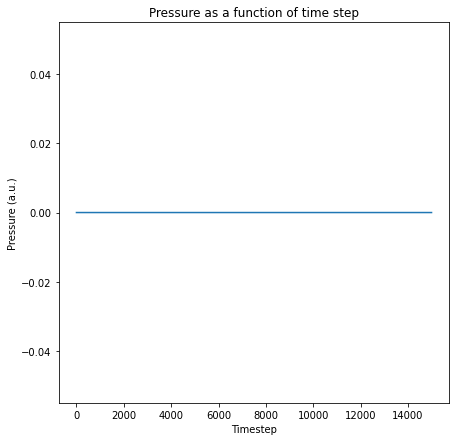

In [46]:
plt.plot(range(len(pressures)), pressures)
plt.xlabel('Timestep')
plt.ylabel('Pressure (a.u.)')
# plt.ylim([0,10])

plt.title('Pressure as a function of time step')
plt.show

* Fix absolute value of pressure

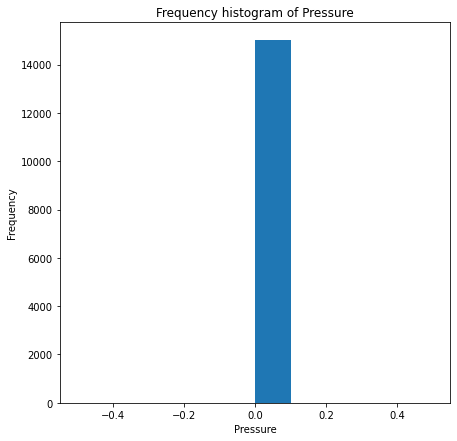

In [47]:
plt.hist(pressures, bins=10)
plt.xlabel('Pressure')
plt.ylabel('Frequency')
plt.gca().set(title='Frequency histogram of Pressure', ylabel='Frequency');

## Calculating Energy

In [48]:
# calculating energy
total_energy = []
total_kinetic_energy = []
total_potential_energy = []
for timestep in df[1:]:
    kinetic_energy = sum(timestep[:,2])
    potential_energy = sum(timestep[:,3])
    total_e = kinetic_energy+potential_energy
    total_kinetic_energy.append(kinetic_energy)
    total_potential_energy.append(potential_energy)
    #divide by avogadro for scaling
    total_energy.append(total_e)

<function matplotlib.pyplot.show(close=None, block=None)>

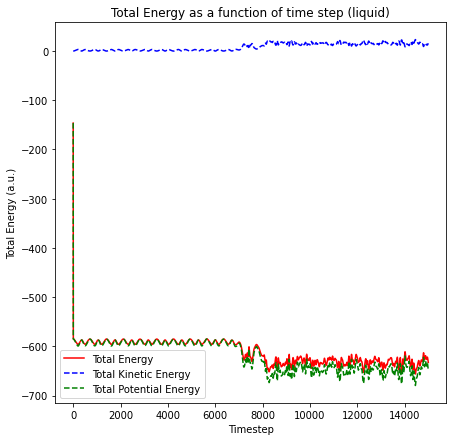

In [49]:
plt.plot(range(len(total_energy)), total_energy, 'r', label='Total Energy')
plt.plot(range(len(total_kinetic_energy)), total_kinetic_energy, 'b--', label='Total Kinetic Energy')
plt.plot(range(len(total_potential_energy)), total_potential_energy, 'g--', label='Total Potential Energy')

plt.xlabel('Timestep')
plt.ylabel('Total Energy (a.u.)')
# plt.ylim([0,10])

plt.title('Total Energy as a function of time step (liquid)')
plt.legend()
plt.show

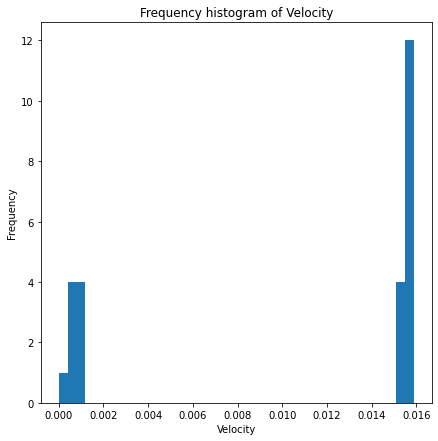

In [249]:
# velocity distribution
vels = df[4][:,5]
plt.hist(vels, bins=40)
plt.xlabel('Velocity')
plt.ylabel('Frequency')
plt.gca().set(title='Frequency histogram of Velocity', ylabel='Frequency');

## Radial Distribution Function


In [250]:
# rdf_data = [timestep][num_particles][num_particles]
# = for each timestep, distance for each particle to each other particle
import os
import time
import numpy as np
from multiprocessing import Pool
from scipy.spatial import cKDTree


def rdf(df, dr, rho=None, rcutoff=0.9, eps=1e-15, parallel=False, progress=False, limit_x=6):
    """
    Computes 2D or 3D radial distribution function g(r) of a set of particle 
    coordinates of shape (N, d). Particle must be placed in a 2D or 3D cuboidal 
    box of dimensions [width x height (x depth)].
    
    Parameters
    ----------
    particles : (N, d) np.array
        Set of particle from which to compute the radial distribution function 
        g(r). Must be of shape (N, 2) or (N, 3) for 2D and 3D coordinates 
        repsectively.
    dr : float
        Delta r. Determines the spacing between successive radii over which g(r)
        is computed.
    rho : float, optional
        Number density. If left as None, box dimensions will be inferred from 
        the particles and the number density will be calculated accordingly.
    rcutoff : float
        radii cutoff value between 0 and 1. The default value of 0.9 means the 
        independent variable (radius) over which the RDF is computed will range 
        from 0 to 0.9*r_max. This removes the noise that occurs at r values 
        close to r_max, due to fewer valid particles available to compute the 
        RDF from at these r values.
    eps : float, optional
        Epsilon value used to find particles less than or equal to a distance 
        in KDTree.
    parallel : bool, optional
        Option to enable or disable multiprocessing. Enabling this affords 
        significant increases in speed.
    progress : bool, optional
        Set to False to disable progress readout (only valid when 
        parallel=False).
        
    
    Returns
    -------
    g_r : (n_radii) np.array
        radial distribution function values g(r).
    radii : (n_radii) np.array
        radii over which g(r) is computed
    """
    
    r_max = limit_x*rcutoff
    radii = np.arange(dr, r_max, dr)

    if not rho:
        rho = len(df[1])/(2*(sim_params['x_lim'] + sim_params['y_lim']))
    
    if parallel:
        N_radii = len(radii)
        radii_and_indices = np.stack([np.arange(N_radii), radii], axis=1)
        radii_splits = np.array_split(radii_and_indices, os.cpu_count(), axis=0)
        values = [(radii_splits[i], tree, particles, mins, maxs, N_radii, dr, eps, rho) for i in range(len(radii_splits))]
        with Pool() as pool:
            results = pool.starmap(paralell_hist_loop, values)
        g_r = np.sum(results, axis=0)
    else:
        g_r = np.zeros(shape=((len(df),len(radii))))
        num_particles = len(df[0])
        for timestep in range(len(df)):
            if timestep % 100 !=0:
                continue
            for r_idx, r in enumerate(radii):

                # compute n_i(r) for particles
                for i in range(num_particles):
                    distances = df[timestep][i]
                    # need to count the number of particles inside r - r+dr-eps 
                    n = len(distances[(distances > r) & (distances < r+dr-eps)])
                    g_r[timestep][r_idx] += n

                # normalize
                shell_vol = np.pi*((r+dr)**2 - r**2)
                g_r[timestep][r_idx] /= num_particles*shell_vol*rho

                if progress:
                    print('Computing RDF     Radius {}/{}    Time elapsed: {:.3f} s'.format(r_idx+1, len(radii), time.time()-start), end='\r', flush=True)
                

    return g_r, radii

In [271]:
g_r, radii = rdf(rdf_data, dr=0.05, limit_x=6)

<function matplotlib.pyplot.show(close=None, block=None)>

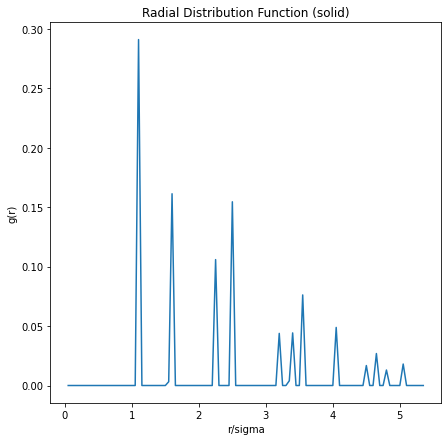

In [273]:
averages = g_r.mean(axis=0)
plt.plot(radii, averages)
plt.xlabel('r/sigma')
plt.ylabel('g(r)')
# plt.ylim([0,10])

plt.title('Radial Distribution Function (solid)')
plt.show